In [17]:
%cd ../../../../test/e2e

[Errno 2] No such file or directory: '../../../../test/e2e'
/home/hoang/Workspace/PRL/other/minhtung0404/cometbft/test/e2e


In [6]:
%cd ../../scripts/qa/reporting/epoch_scripts

/home/hoang/Workspace/PRL/other/minhtung0404/cometbft/scripts/qa/reporting/epoch_scripts


In [18]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess
import os
import json

In [ ]:
test_states = 8
iterations = 2

timeout = 300

json_stats = dict()

for n_states in range(1, test_states + 1):
    print(f"---- Starting test of n_states {n_states} ----")

    json_stats[n_states] = []

    with open("networks/simple.toml", "r") as src:
        with open("networks/simple_modified.toml", "w") as dst:
            for l in src:
                if l.startswith("n_states"):
                    dst.write(f"n_states = {n_states}")
                else:
                    dst.write(l)
    
    with open("benchmark.txt", "w") as f:
        f.write("")
    
    success = 0
    for i in range(iterations):
        try:
            subprocess.run(["./build/runner", "-f", "networks/simple_modified.toml", "benchmark"], timeout=timeout)
            success += 1
        except:
            print(f"Timing out after {timeout}s")
            if success == 0 and i == iterations - 1:
                i -= 1

    with open("benchmark.txt", "r") as f:
        for l in f:
            json_stats[n_states].append(l)

    print("Updated json_stats")
    print(json_stats)

with open("benchmark_total.txt", "w") as f:
    f.write(json.dumps(json_stats))

---- Starting test of n_states 1 ----
I[2025-05-22|22:51:39.318] Removing Docker containers and networks      
I[2025-05-22|22:51:39.349] setup                                        msg="Generating testnet files in `networks/simple_modified`"
I[2025-05-22|22:51:39.363] Starting initial network nodes...            
I[2025-05-22|22:51:39.364] load                                         msg="Starting transaction load (16 workers)..."
E[2025-05-22|22:51:39.365] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5710/v1\": dial tcp 127.0.0.1:5710: connect: connection refused"
E[2025-05-22|22:51:39.365] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5704/v1\": dial tcp 127.0.0.1:5704: connect: connection refused"
D[2025-05-22|22:51:39.365] load                                         success=0 failed=2 success/total=0.00 tx/s=0.0
E[2025-05-22|22:51:39.414] failed to send transaction                   err="fai

In [42]:
with open("benchmark_total.txt", "r") as f:
    json_stats = json.load(f)
print("Last json_stats")
print(json_stats)

Last json_stats
{'1': ['{"blocks":99,"case":"simple_modified.toml","dur":143.322152094,"end_height":106,"max":2.02764553,"mean":1.432648615,"min":1.295225815,"n_states":1,"size":4,"start_height":7,"stddev":0.12316738144716782,"txns":200}\n', '{"blocks":99,"case":"simple_modified.toml","dur":136.581094114,"end_height":106,"max":1.4548176879999999,"mean":1.365561357,"min":1.270358759,"n_states":1,"size":4,"start_height":7,"stddev":0.04302821695518823,"txns":200}\n'], '2': ['{"blocks":97,"case":"simple_modified.toml","dur":70.089557041,"end_height":107,"max":1.463849946,"mean":0.693442459,"min":8.52e-7,"n_states":2,"size":4,"start_height":10,"stddev":0.4100801977764557,"txns":200}\n', '{"blocks":99,"case":"simple_modified.toml","dur":68.283609312,"end_height":108,"max":1.396753388,"mean":0.671651196,"min":0.000001002,"n_states":2,"size":4,"start_height":9,"stddev":0.5421302565973402,"txns":200}\n'], '3': ['{"blocks":99,"case":"simple_modified.toml","dur":47.183996007,"end_height":111,"max

In [43]:
mean_times = dict()
max_times = dict()
min_times = dict()

for n_states, stats in json_stats.items():
    mean_times[n_states] = 0
    max_times[n_states] = -1000
    min_times[n_states] = 1000

    for json_stat in stats:
        stat = json.loads(json_stat)
        mean_times[n_states] += stat["mean"]
        max_times[n_states] = max(max_times[n_states], stat["max"])
        min_times[n_states] = min(min_times[n_states], stat["min"])
    mean_times[n_states] /= len(stats)

print(f"Stats for all {len(mean_times)} tests")
for n_states in mean_times:
    print(f"Stats for {n_states}: Mean {mean_times[n_states]} max {max_times[n_states]} min {min_times[n_states]}")

Stats for all 8 tests
Stats for 1: Mean 1.399104986 max 2.02764553 min 1.270358759
Stats for 2: Mean 0.6825468275 max 1.463849946 min 8.52e-07
Stats for 3: Mean 0.463446551 max 1.418935392 min 1e-08
Stats for 4: Mean 0.33046553300000003 max 1.260609829 min 7e-08
Stats for 5: Mean 0.26884636149999996 max 1.314259077 min 1e-08
Stats for 6: Mean 0.225691398 max 1.25923327 min 1e-08
Stats for 7: Mean 0.20245255299999998 max 1.4133119330000001 min 5e-08
Stats for 8: Mean 0.184452115 max 1.4364921929999999 min 2e-08


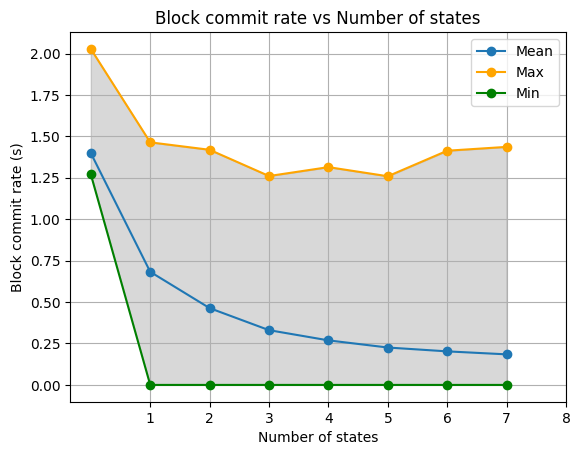

In [44]:
# plotting inv_throughput

plt.plot(mean_times.keys(), mean_times.values(), marker='o')
plt.plot(max_times.keys(), max_times.values(), marker='o', color='orange')
plt.plot(min_times.keys(), min_times.values(), marker='o', color='green')
plt.fill_between(mean_times.keys(), min_times.values(), max_times.values(), color='gray', alpha=0.3)
plt.legend(["Mean", "Max", "Min"])

plt.xlabel("Number of states")
plt.ylabel("Block commit rate (s)")
plt.title("Block commit rate vs Number of states")
plt.xticks(range(1, len(mean_times) + 1), range(1, len(mean_times) + 1))
plt.grid()
plt.savefig("block_commit_rate.png")
plt.show()

In [40]:
print(throughput)

{1: 0.7147426461962447, 2: 1.4651009421034926, 3: 2.1577461259389112, 4: 3.0260341855378905, 5: 3.719596554777998, 6: 4.430829038508592, 7: 4.939428943630067, 8: 5.421461282783339, 0: 0.7292837529453009}


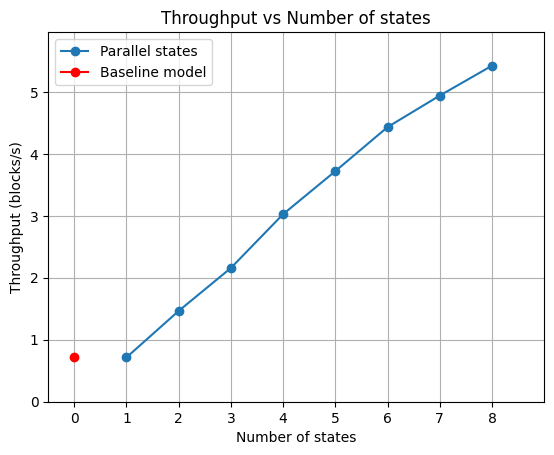

In [50]:
throughput = dict()
for n_states in mean_times:
    throughput[int(n_states)] = 1 / mean_times[n_states]
    
plt.plot(throughput.keys(), throughput.values(), marker='o')
# plot point (0, 1.371208389)
plt.plot(0, 1 / 1.371208389, marker='o', color='red')

plt.legend(["Parallel states", "Baseline model"])

plt.xlabel("Number of states")
plt.ylabel("Throughput (blocks/s)")
plt.title("Throughput vs Number of states")
plt.xticks(range(0, len(throughput) + 1), range(0, len(throughput) + 1))
plt.xlim(-0.5, len(throughput) + 1)
plt.ylim(0, max(throughput.values()) * 1.1)
plt.grid()
plt.savefig("throughput_vs_nstates.png")
plt.show()